# Kalman filter and Hungarian algorithm as assignment method

In [ ]:
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment

class KalmanFilter:
    def __init__(self):
        self.kf = cv2.KalmanFilter(4, 2)
        self.kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
        self.kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
        self.kf.processNoiseCov = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32) * 0.03

    def predict(self):
        return self.kf.predict()

    def correct(self, coordX, coordY):
        measurement = np.array([[np.float32(coordX)], [np.float32(coordY)]])
        self.kf.correct(measurement)

def track_dots(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    positions = []
    next_id = 0
    prev_positions = {}
    kalman_filters = {}
    line_position = 800  # Define the horizontal line position
    cross_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame[525:1128, 400:1500]

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        current_positions = {}
        centroids = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))

        if prev_positions:
            predicted_positions = {}
            for dot_id, kf in kalman_filters.items():
                predicted = kf.predict()
                predicted_positions[dot_id] = (predicted[0], predicted[1])

            cost_matrix = np.zeros((len(predicted_positions), len(centroids)))
            prev_ids = list(predicted_positions.keys())

            for i, prev_id in enumerate(prev_ids):
                for j, centroid in enumerate(centroids):
                    cost_matrix[i, j] = np.linalg.norm(np.array(predicted_positions[prev_id]) - np.array(centroid))

            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            assigned_centroids = set()
            for i, j in zip(row_ind, col_ind):
                current_positions[prev_ids[i]] = centroids[j]
                kalman_filters[prev_ids[i]].correct(centroids[j][0], centroids[j][1])
                assigned_centroids.add(j)

            for j, centroid in enumerate(centroids):
                if j not in assigned_centroids:
                    current_positions[next_id] = centroid
                    kalman_filters[next_id] = KalmanFilter()
                    kalman_filters[next_id].correct(centroid[0], centroid[1])
                    next_id += 1
        else:
            for centroid in centroids:
                current_positions[next_id] = centroid
                kalman_filters[next_id] = KalmanFilter()
                kalman_filters[next_id].correct(centroid[0], centroid[1])
                next_id += 1

        positions.append(current_positions)
        prev_positions = current_positions

        for dot_id, (cx, cy) in current_positions.items():
            if cx > line_position and prev_positions[dot_id][0] <= line_position:
                cross_count += 1
            cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)
            cv2.putText(frame, str(dot_id), (cx + 5, cy - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        cv2.line(frame, (line_position, 0), (line_position, frame.shape[0]), (255, 0, 0), 2)
        cv2.putText(frame, f'Cross Count: {cross_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow('Tracking', frame)
        if cv2.waitKey(int((1/fps)*1000*10)) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return positions

# Example usage:
video_path = "241220_J10_DicerII_Chloe.avi"
positions = track_dots(video_path)

# Automated performance index

In [70]:
import cv2
import numpy as np

video_path = "20241223_J15_DicerII_Chloe_28858_104363_W118H_W118_47636.avi"
genotypes = [
    'candidate',
    'Parkin',
    'w',
    'w',
    'Parkin'
]
fps = 10

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Cannot open video file {video_path}")
    exit()

counts = []
total = []

# Define 5 fixed ROIs (x, y, width, height) -> Corrected order
rois = {
    "ROI_1": (410, 517, 135, 610),
    "ROI_2": (620, 517, 135, 610),
    "ROI_3": (828, 517, 135, 610),
    "ROI_4": (1035, 517, 135, 610),
    "ROI_5": (1242, 517, 135, 610),
}

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Error: Frame not read correctly")
        break

    height, width = frame.shape[:2]  # Get frame dimensions

    combined_frame = None
    for name, (x, y, w, h) in rois.items():
        # Ensure ROI does not exceed frame size
        if x < 0 or y < 0 or x + w > width or y + h > height:
            print(f"Skipping invalid ROI {name}: {x, y, w, h} (Out of bounds)")
            continue

        # Correct slicing order: frame[y:y+h, x:x+w]
        framecrop = frame[y:y+h, x:x+w]

        if framecrop.size == 0:
            print(f"Skipping empty crop for {name}")
            continue

        gray = cv2.cvtColor(framecrop, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        centroids = []
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))
                # Draw red dot on the centroid
                cv2.circle(framecrop, (cx, cy), 5, (0, 0, 255), -1)

        line_position = h // 2  # Compute once per ROI
        counts.append(sum(1 for _, cy in centroids if line_position - 10 <= cy <= line_position + 10))
        total.append(len(contours))

        # Combine the frames side by side
        if combined_frame is None:
            combined_frame = framecrop
        else:
            combined_frame = np.hstack((combined_frame, framecrop))

    if combined_frame is not None:
        cv2.imshow("Combined ROIs", combined_frame)

    if cv2.waitKey(int((1 / fps) * 1000)) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

counts = np.transpose(np.array(counts).reshape(-1, 5))
total =np.transpose(np.array(total).reshape(-1, 5))

Error: Frame not read correctly


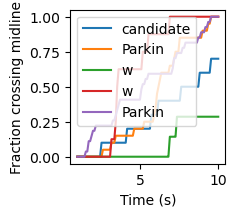

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(2, 2))
for i, count in enumerate(counts):
    if np.cumsum(count)[-1]>np.max(total[i]):
        plt.plot(np.linspace(1,10,100),np.cumsum(count)/np.cumsum(count)[-1], label=genotypes[i])
    else:
        plt.plot(np.linspace(1,10,100),np.cumsum(count)/np.max(total[i]), label=genotypes[i])
plt.xlabel('Time (s)')
plt.ylabel('Fraction crossing midline')
plt.legend()
plt.show()


In [14]:
max(counts)

2

In [26]:
# Step 1: Get all unique animal IDs
animal_ids = set()
for frame in positions:
    animal_ids.update(frame.keys())

animal_ids = sorted(animal_ids)  # Sorting for consistent indexing

# Step 2: Initialize an empty ndarray to store the positions
num_animals = len(animal_ids)
num_frames = len(positions)

# Initialize the ndarray with NaN values to fill in missing data
position_array = np.full((num_animals, 2, num_frames), np.nan)

# Step 3: Populate the ndarray with x, y positions
for frame_idx, frame in enumerate(positions):
    for animal_idx, animal_id in enumerate(animal_ids):
        if animal_id in frame:
            x, y = frame[animal_id]
            position_array[animal_idx, 0, frame_idx] = x  # Set x position
            position_array[animal_idx, 1, frame_idx] = y  # Set y position

# Now `position_array` contains the positions with shape (num_animals, 2, num_frames)
print(position_array.shape)  # This should output (number_of_animals, 2, 100)
positions = np.ma.masked_array(position_array, mask=np.isnan(position_array))

(277, 2, 100)


In [27]:
import numpy as np

def compute_displacements(positions):
    """
    Computes cumulative displacements in x and y directions for each animal.
    
    Parameters:
    positions (np.ma.MaskedArray): Masked array of shape (num_animals, 2, num_frames)
    
    Returns:
    np.ma.MaskedArray: Cumulative displacements of shape (num_animals, 2, num_frames-1)
    """
    # Compute frame-to-frame displacements (difference along time axis)
    displacements = np.diff(positions, axis=2)
    
    # Compute cumulative sum to get cumulative displacement
    cumulative_displacements = np.ma.cumsum(displacements, axis=2)
    
    return cumulative_displacements

# Example usage:
# Assuming `positions` is a masked ndarray with shape (286, 2, 100)
displacements = compute_displacements(positions)
print(displacements.shape)  # Expected output: (286, 2, 99)


(277, 2, 99)


ValueError: array is read-only

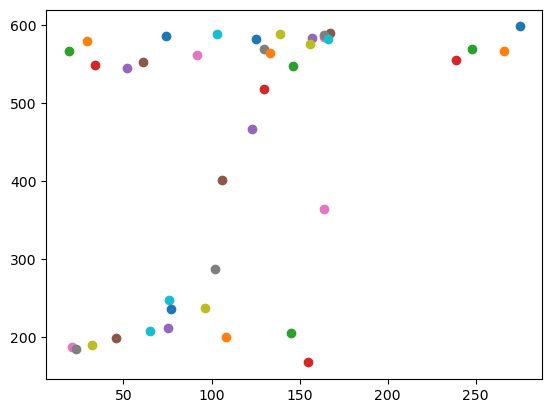

In [28]:
i = 0
for t in range(positions.shape[2]):
    plt.scatter(positions[i,0,t], positions[i,1,t])

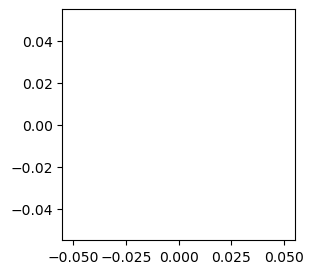

In [4]:
plt.figure(figsize=(3, 3))
plt.plot(result1[0])
plt.show()